In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1.0e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 10             # amplitude of modal source (A/L0^2?)

In [4]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [5]:
# geometric parameters
L = 8         # length of box (L0)
H = 6         # height of box (L0)
w = .4        # width of waveguides (L0)
d = 3         # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 2       # space between box and PML (L0)

Computed a domain with 190 grids in x and 130 grids in y
The simulation has 20 grids per free space wavelength


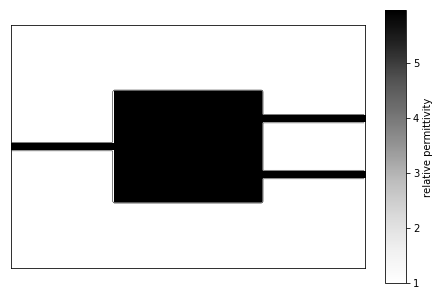

In [6]:
# define permittivity of three port system
eps_r, design_region = three_port(L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [7]:
# check to make sure the number of points in each waveguide is the same
eps = simulation.eps_r
pts_in = np.sum(eps[NPML[0]+3,:] > 1)
pts_top = np.sum(eps[-NPML[0]-3,:ny] > 1)
pts_bot = np.sum(eps[-NPML[0]-3,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))
assert pts_in == pts_top == pts_bot, "number of grid points in each waveguide is not consistent"

waveguide has 4 points in in port
waveguide has 4 points in top port
waveguide has 4 points in bottom port


In [8]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
top = Simulation(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], int(H/2/dl))
top.setup_modes()
J_top = np.abs(top.src)

# bottom modal profile
bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], int(H/2/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

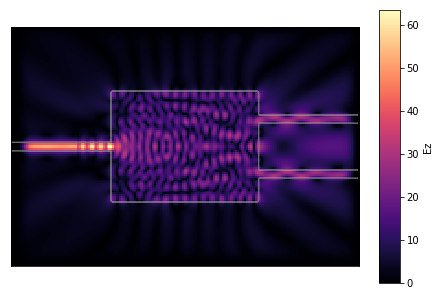

In [9]:
# solve for electromagnetic fields
_ = simulation.solve_fields()

simulation.plt_abs(outline=True, cbar=True)
plt.show()

In [11]:
# Try a linear optimization
import autograd.numpy as npa
def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top)

In [13]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=100, eps_max=eps_m, max_ind_shift=max_ind_shift)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-4.25817651690499, -0.8011116635530691, 7.041975940293323, -1.4331013644060104]
numerical gradient = [-4.2582033938742825, -0.8011250565687078, 7.042011823159555, -1.4331312559079379]


In [14]:
optimization.run(simulation, design_region, method='lbfgs')

 ObjectiveFn: ------ ObjectiveFn_Normalized: ------ Iteration:  0/100 ETA:  --:--:--

KeyboardInterrupt: 

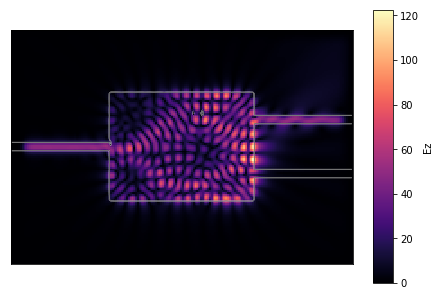

In [28]:
# solve for electromagnetic fields
_ = simulation.solve_fields()

simulation.plt_abs(outline=True, cbar=True)
plt.show()

 ObjectiveFn: 4.2e+03 Iteration:  99/100 ETA:   0:00:00                        

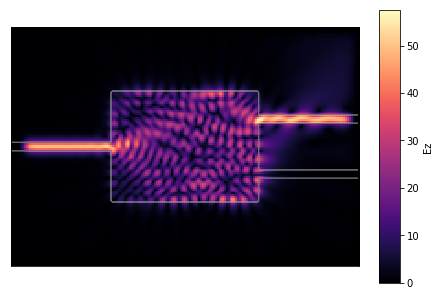

In [29]:
simulation.eps_r = eps_r
eps_lin1 = optimization.run(simulation, design_region, method='adam')

_ = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

In [41]:
# Now try a nonlinear optimization
def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top)*npa.sum(npa.square(npa.abs(e_nl))*J_bot)

In [42]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=100, eps_max=eps_m)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-105.47207699966434, 127.45607685892358, 1348.1820344477019, -1451.3522644775862]
numerical gradient = [-105.47054258495336, 127.4799323073239, 1348.192774457857, -1451.3315111253178]


In [43]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

 ObjectiveFn: 4.5e+06 Iteration:  99/100 ETA:   0:00:01                        

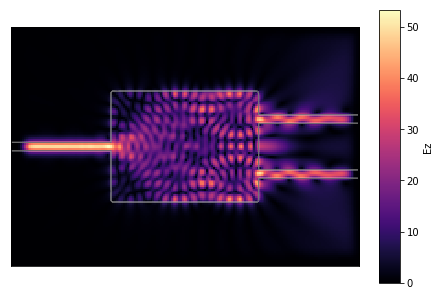

In [44]:
simulation.eps_r = eps_r
eps_nonlin1 = optimization.run(simulation, design_region, method='adam')

_ = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

 ObjectiveFn: 1.17e+07 Iteration:  99/100 ETA:   0:00:06                       

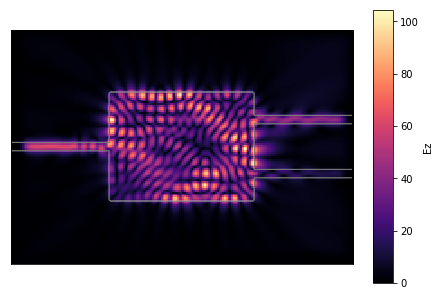

In [45]:
simulation.eps_r = eps_r
eps_nonlin1 = optimization.run(simulation, design_region, method='lbfgs')

_ = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

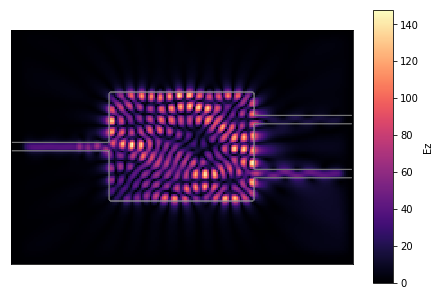

In [46]:
_ = simulation.solve_fields_nl()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

maximum refractive index shift of 0.0053791719268496685


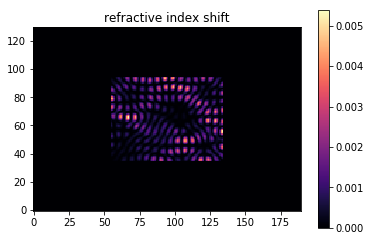

In [47]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

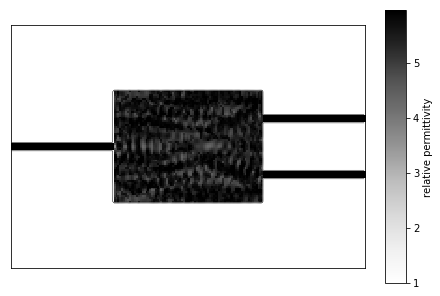

In [48]:
simulation.plt_eps(cbar=True)
plt.show()

adjoint gradient   = [-7.41235286210731, -0.7388194635208123, -7.9910790034591335, 2.187386555938051]
numerical gradient = [-7.4124502134509385, -0.7388294852717081, -7.9911425928003155, 2.187368418162805]


 ObjectiveFn: 4.28e+03 Iteration:  99/100 ETA:   0:00:02                       

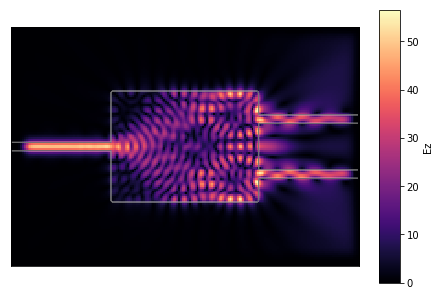

In [49]:
simulation.eps_r = eps_r

# Now try a nonlinear optimization
def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top) + npa.sum(npa.square(npa.abs(e_nl))*J_bot)

# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=100, eps_max=eps_m)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

eps_nonlin2 = optimization.run(simulation, design_region, method='adam')

_ = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

 ObjectiveFn: 5.35e+03 Iteration:  99/100 ETA:   0:00:05                       

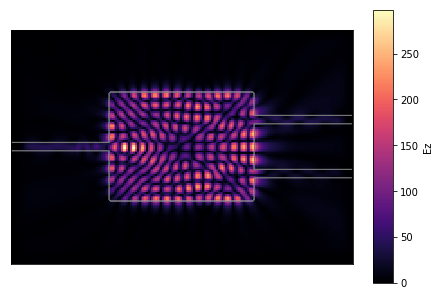

In [50]:
simulation.eps_r = eps_r

eps_nonlin2 = optimization.run(simulation, design_region, method='lbfgs')

_ = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

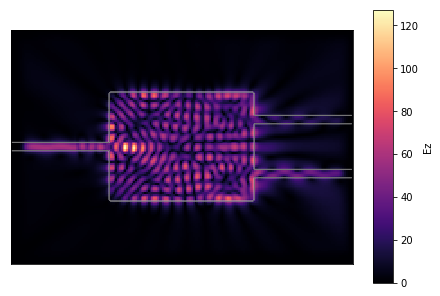

In [51]:
_ = simulation.solve_fields_nl()
simulation.plt_abs(outline=True, cbar=True)
plt.show()

In [57]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=5)
simulation.setup_modes()
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

def J(e, e_nl, eps):
    return npa.sum(npa.square(npa.abs(e))*J_top)*npa.sum(npa.square(npa.abs(e_nl))*J_bot)

# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=400, eps_max=eps_m)
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

eps_nonlin3 = optimization.run(simulation, design_region, method='lbfgs')

adjoint gradient   = [1708.663665694265, 572.2357818785703, -872.1999608330295, -241.93717793970472]
numerical gradient = [1708.6654882587027, 572.235772269778, -872.2101821331307, -241.9407972774934]


 ObjectiveFn: 7.96e+05 Iteration:  399/400 ETA:   0:00:06                      

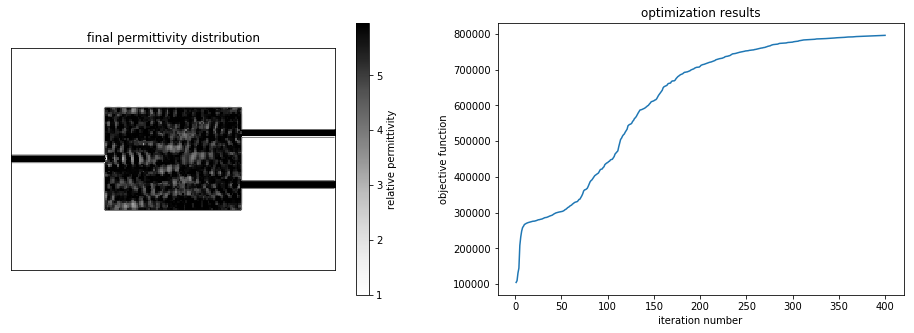

In [58]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

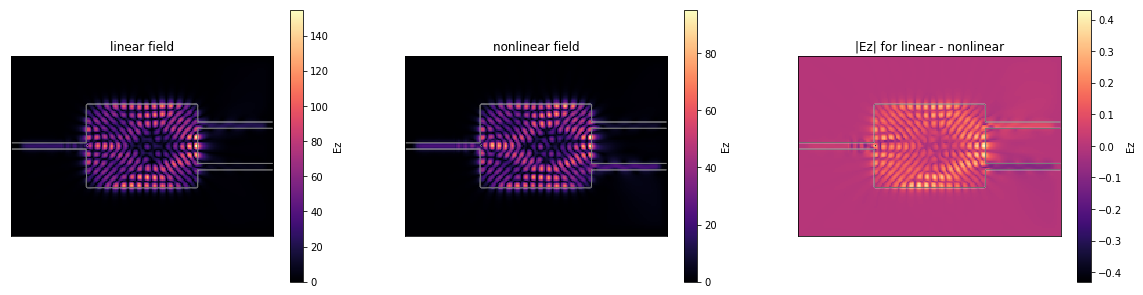

maximum refractive index shift of 0.00226887175019419


In [62]:
# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))

In [61]:
# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


linear transmission              = 0.9404
nonlinear transmission           = 0.9471

relative power difference        = 0.71 %
relative transmission difference = 0.71 %
